In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import pandas as pd
from scipy import stats
from kuramoto import *

## Firstly, read data from file

In [2]:
filename = 'Data/skeleton_xyz_stage_all.csv'
df = pd.read_csv(filename)

### Read in all the stage data, and group each tubule together

In [3]:
stages = df['Stage'].to_numpy().astype('int')
tubules = df['Tubule_ID'].to_numpy().astype('int')
branches = df['Branch_ID'].to_numpy().astype('int')
refs = df['Ref']

datasets = [] 
for i in range(1, 10): 
    mask = (tubules == i)
    tubule_stage = stages[mask] 
    tubule_branches = branches[mask]
    tubule_refs = refs[mask]
    tubule_dataset = [] 
    for j in range(1, tubule_branches[-1]+1):
        mask = (tubule_branches == j)
        branch_stages = tubule_stage[mask]
        branch_dataset = {
            'start': (tubule_refs[mask]).iloc[0], 
            'end': (tubule_refs[mask]).iloc[-1], 
            'stages': branch_stages,
        }
        tubule_dataset.append(branch_dataset)

    datasets.append(tubule_dataset)      

### Print out the start and end points of each tubule to manually read off the longest section (ish) 

In [4]:
for (i, dataset) in enumerate(datasets): 
    for d in dataset: 
        stages = d['stages']     

### Extract the longest sections

In [5]:
orders = [[2, 0, 4], [0, 1], [0, 1], [6, 7, 9], [0, 2], [0], [0], [0, 1], [5, 6, 8]]
reverse = [[True, False, False], [False, False], [True, False], [True, False, False], [True, False], [False], [False], [True, False], [True, False, False]]

segments = [] 
for (i, (order, rev, dataset)) in enumerate(zip(orders, reverse, datasets)): 
    print('tubule ID:', i+1)
    segment = [] 
    for (j, segment_index) in enumerate(order): 
        stages = dataset[segment_index]['stages']
        if rev[j]: 
            stages = np.flip(stages)
        segment.extend(stages)
    segment = np.array(segment)
    segments.append(segment)
        
print(list(map(len, segments)))       

tubule ID: 1
tubule ID: 2
tubule ID: 3
tubule ID: 4
tubule ID: 5
tubule ID: 6
tubule ID: 7
tubule ID: 8
tubule ID: 9
[10813, 9301, 10931, 11495, 8698, 6629, 12111, 14388, 7707]


### Replace the invalid datapoints with averages of neighbours 

In [6]:
straight_segments = [] 
for (i, segment) in enumerate(segments): 
    boolean_mask = is_invalid(segment).astype('int')
    left = np.where((np.roll(boolean_mask, -1) - boolean_mask) > 0)[0]
    right = np.where((np.roll(boolean_mask, 1) - boolean_mask) > 0)[0]

    
    if right[0] < left[0]: # invalid segments at the start 
        right = right[1:]
    if left[-1] > right[-1]: # invalid segments at the end 
        left = left[:-1]
    
    for (l, r) in zip(left, right): # pairs of indices between which the values are invalid         
        val = period_average(segment[l], segment[r])
        segment[l+1:r] = val 
        
        
    new_mask = is_invalid(segment)
    straight_segments.append(segment[~new_mask])  

In [36]:
L = 160
mfreq = np.fft.rfftfreq(L)[1:]
dk = mfreq[2]/2 
bins = np.append(mfreq, mfreq[-1]+dk)
bins -= dk/2 

def average_scatter(x, y): 
    return [np.mean(y[x==i]) for i in np.unique(x).astype('int')]

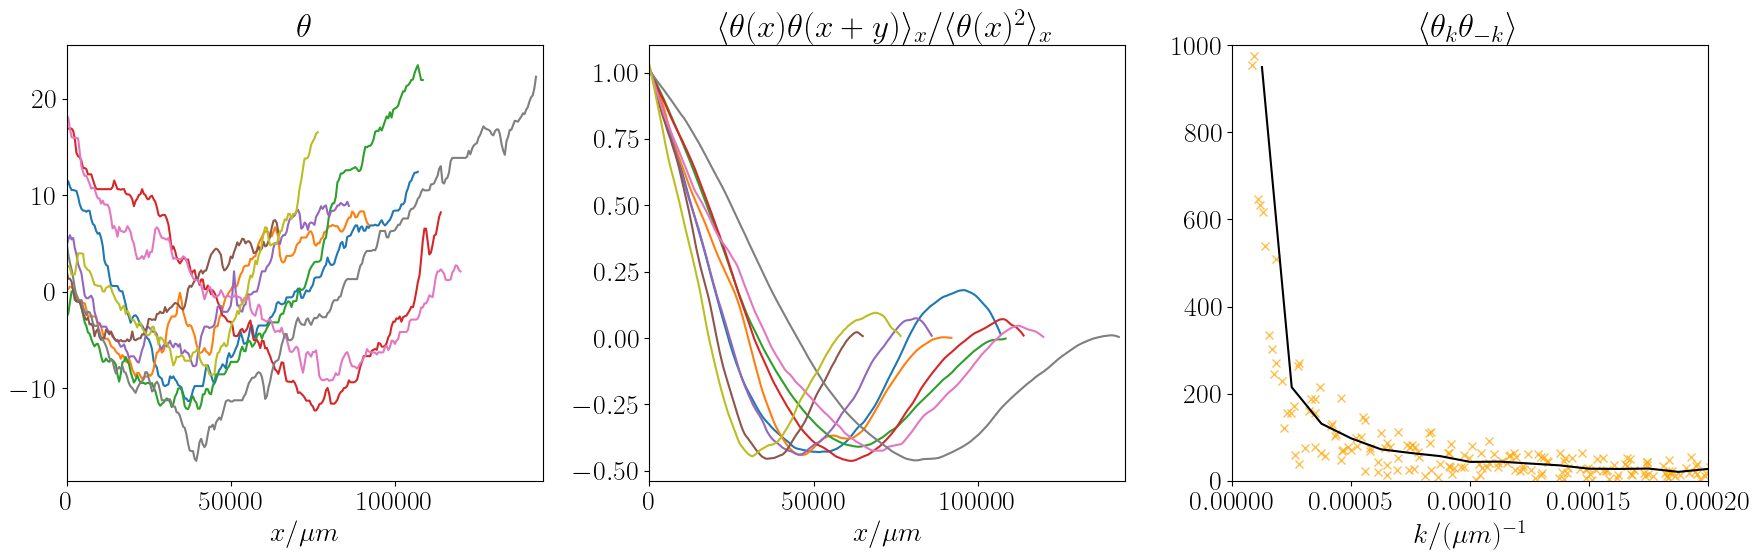

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.rc('text', usetex=True)
plt.rc('font', size=20, family='serif')

indices = [] 
theta_ks = [] 

for (n, stages) in enumerate(straight_segments): 
    phases = np.array(list(map(stage_to_phase, stages)))    
    
    shift(phases)
    theta_smooth = smooth(phases, 50)
    L = len(theta_smooth)
    x = np.arange(L)*500
    
    theta = theta_smooth - np.mean(theta_smooth)
    axes[0].plot(x, theta, color=plt.cm.tab10(n))

    corr = np.correlate(theta, theta, mode='full')
    axes[1].plot(x, corr[L-1:]/corr[L], color=plt.cm.tab10(n))
    
    freq = np.fft.rfftfreq(L)[1:]
    indices.extend(np.digitize(freq, bins))
    theta_k = np.abs(np.fft.rfft(theta))[1:]
    theta_ks.extend(theta_k)
    axes[2].plot(freq/500, theta_k, 'x', color='orange', alpha=0.7)
    
mtheta_k = average_scatter(np.array(indices), np.array(theta_ks))
axes[2].plot(mfreq/500, mtheta_k, color='k')

axes[0].set_xlim([0, 290*500])
axes[1].set_xlim([0, 290*500])
axes[2].set_xlim([0, 0.0002])
axes[2].set_ylim([0, 1000])
axes[0].set_xlabel('$x/\mu m $')
axes[1].set_xlabel('$x/\mu m $')
axes[2].set_xlabel('$k/(\mu m)^{-1}$')

axes[0].set_title(r'$\theta$')
axes[1].set_title(r'$\langle \theta(x)\theta(x+y) \rangle_x / \langle \theta(x)^2 \rangle_x $')
axes[2].set_title(r'$\langle \theta_k \theta_{-k} \rangle $')
plt.tight_layout()
plt.savefig('Figures/data_corr.pdf')

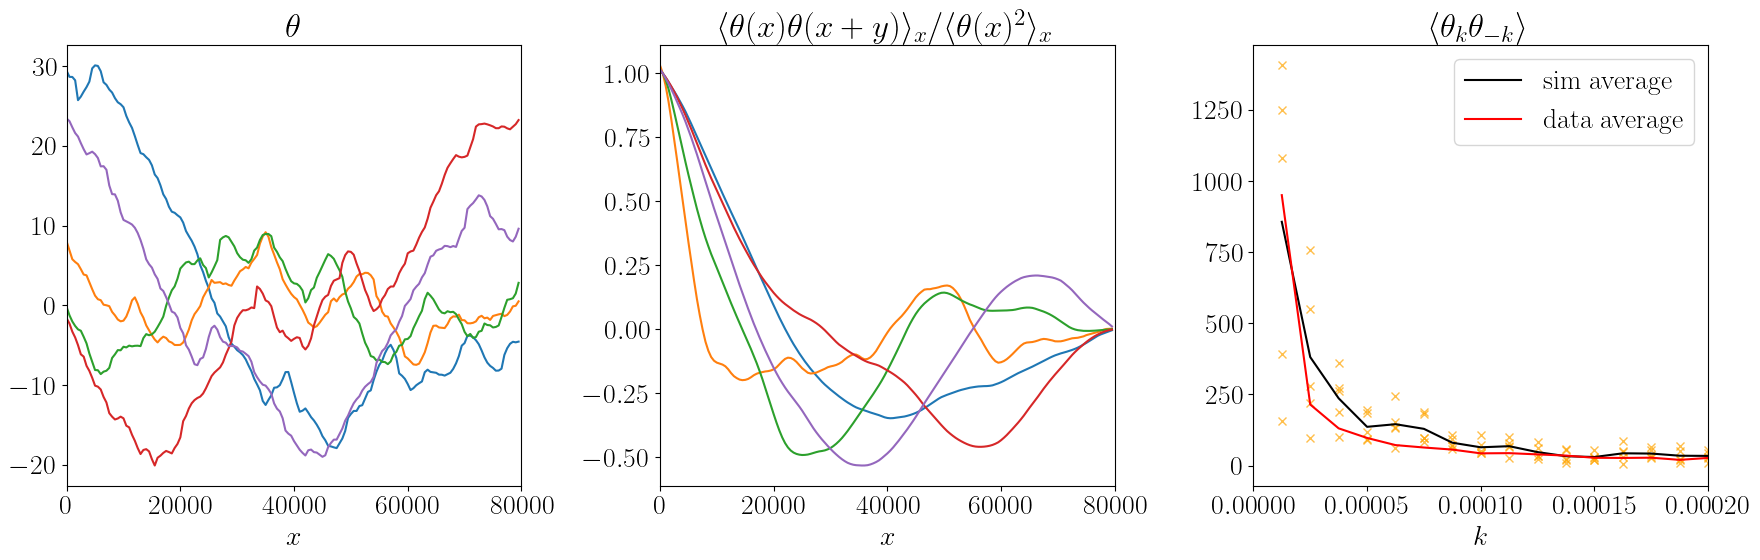

In [42]:
eta = -0.44
sigma = 0.45
data = np.load('Sims/data_sigma={}_eta={}_samples.npy'.format(sigma, eta))

# replot the best fit parameters 
theta_ks = [] 

L = 160
x = np.arange(L)*500

plt.rc('text', usetex=True)
plt.rc('font', size=20, family='serif')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for (n, theta) in enumerate(data): 
    theta = theta - np.mean(theta)
    axes[0].plot(x, theta, color=plt.cm.tab10(n))

    L = len(theta)
    corr = np.correlate(theta, theta, mode='full')
    axes[1].plot(x, corr[L-1:]/corr[L], color=plt.cm.tab10(n))


    freq = np.fft.rfftfreq(L)[1:]
    theta_k = np.abs(np.fft.rfft(theta))[1:]
    axes[2].plot(freq/500, theta_k, 'x', color='orange', alpha=0.7)
    theta_ks.append(theta_k)
    i += 1
        
    
m = np.mean(theta_ks, axis=0)
axes[2].plot(freq/500, m, color='black', label='sim average')
axes[2].plot(freq/500, mtheta_k, color='red', label='data average')
axes[2].legend()

axes[0].set_xlim([0, 160*500])
axes[1].set_xlim([0, 160*500])
axes[2].set_xlim([0, 0.1/500])
axes[0].set_xlabel(r'$x$')
axes[1].set_xlabel(r'$x$')
axes[2].set_xlabel(r'$k$')

axes[0].set_title(r'$\theta$')
axes[1].set_title(r'$\langle \theta(x)\theta(x+y) \rangle_x / \langle \theta(x)^2 \rangle_x $')
axes[2].set_title(r'$\langle \theta_k \theta_{-k} \rangle $')
plt.tight_layout()
plt.savefig('Figures/map_sim.pdf')
plt.show() 

## Perform inference on each tubule separately

In [10]:
# Set up model parameters 
epsilon = 1
eta = -0.44
sigma = 0.1
mean_omega = 0
noise = 0.45


# Set up simulation parameters 
L = 200
T = 3e4 # total time of the simulation 
n_frames = T # number of time points recorded in the end 
init = np.zeros(L)
grad = 1.3
grads = [-grad, grad]
seeds = [None]*8

data = [] 
# Initialise the model and run the simulation 

sigmas = [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12]

data = [] 
for sigma in sigmas: 
    noise = np.sqrt(0.45**2-sigma**2)
    for seed in seeds: 
        model = KuramotoVF(epsilon, eta, sigma, mean_omega, noise=noise, BC='grad', grad=grads)
        model.initialise(L, T, n_frames, init=init, seed=seed)
        model.evolve(dt=1e-2) 

        phases = np.copy(model.res[-1]) % (2*np.pi)
        shift(phases)
        data.append(phases)

100%|█████████████████████████████████████| 30000/30000 [16:43<00:00, 29.89it/s]


969.5343672102721
1509.0933869830953
902.9639953658481
722.2682893435837
1645.006496365535
2449.1817970658562
2415.673364099735


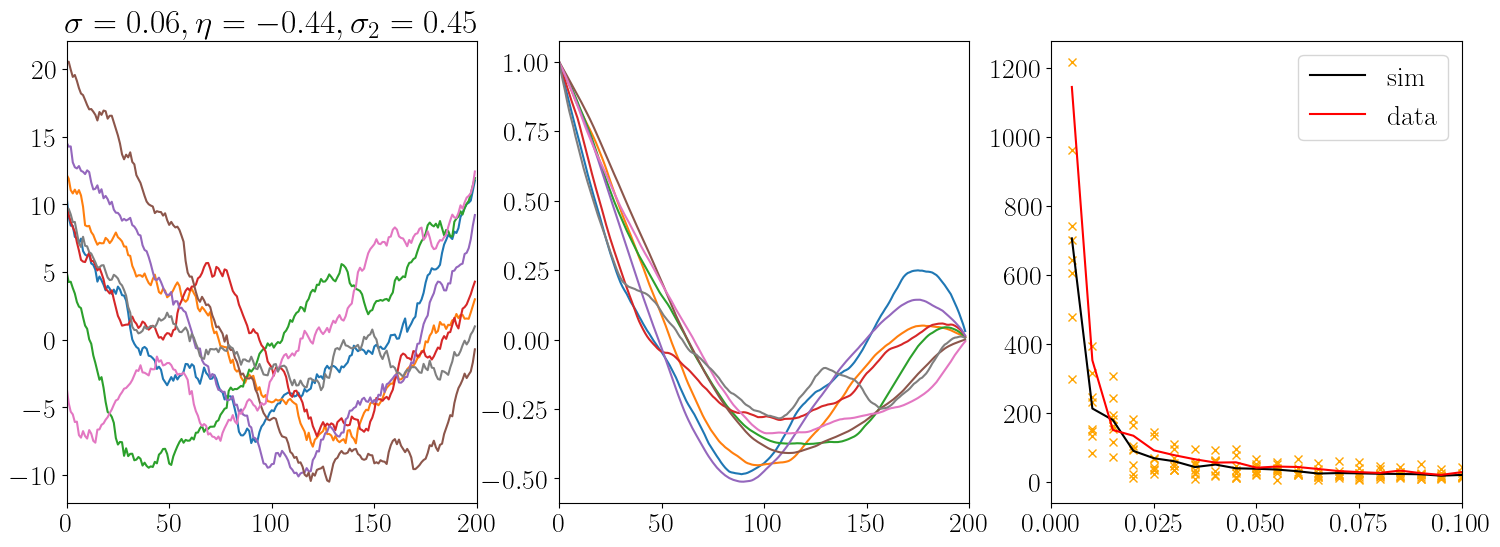

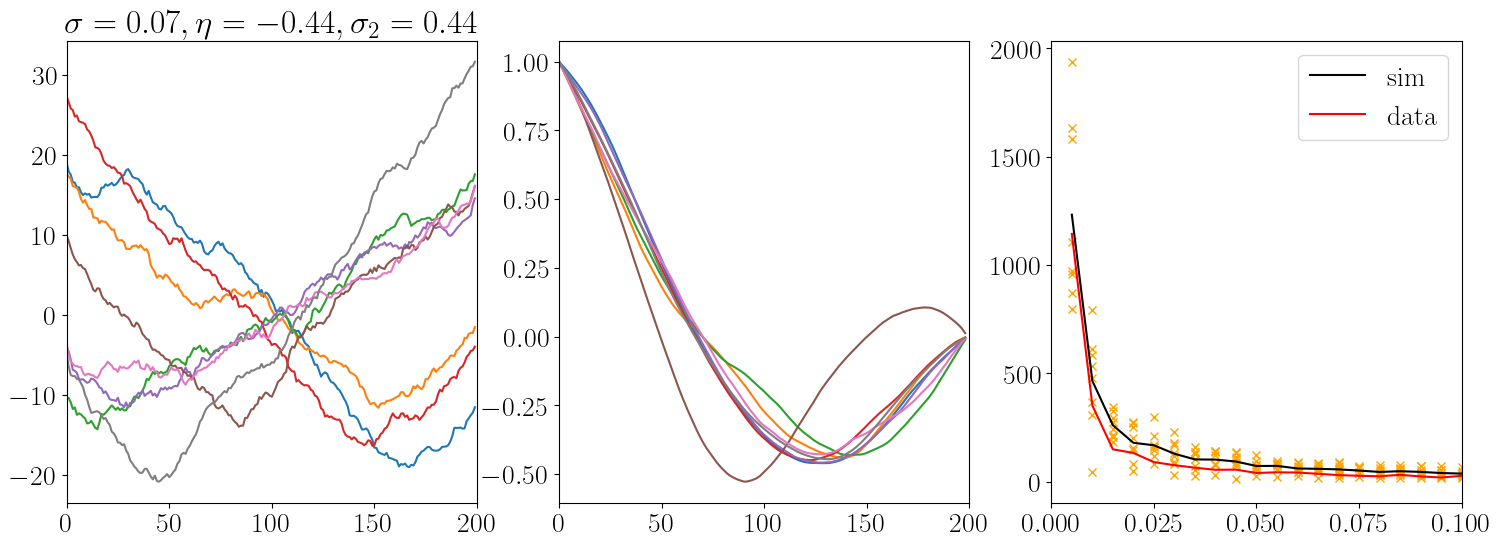

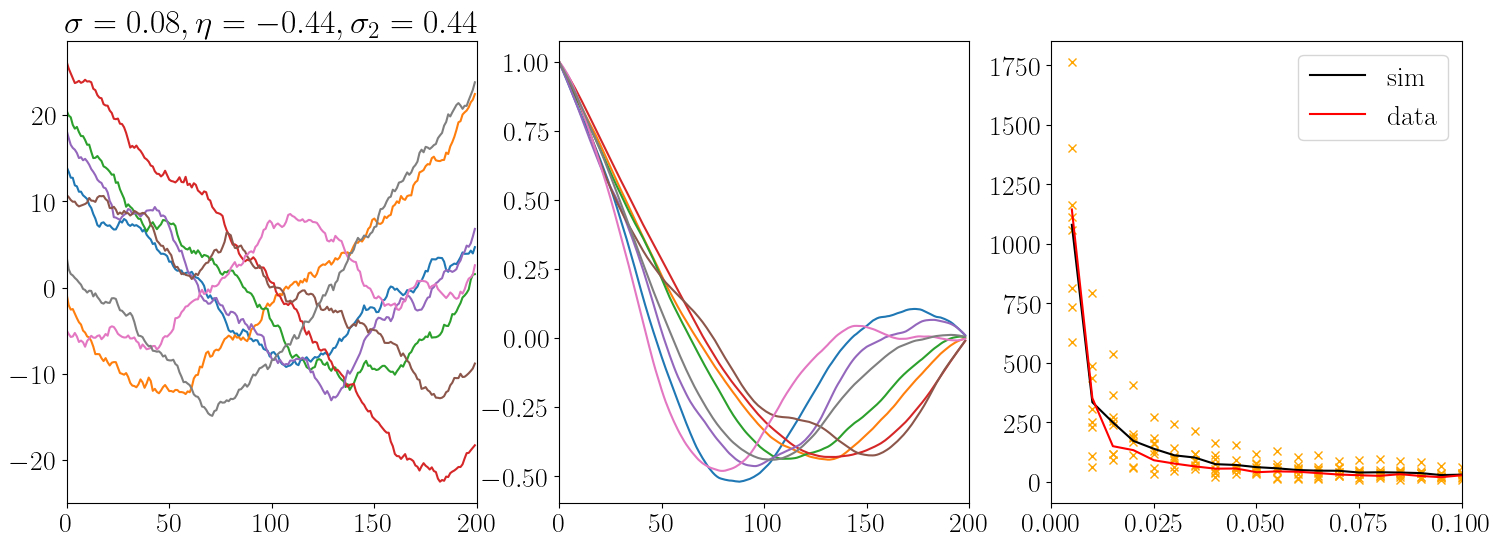

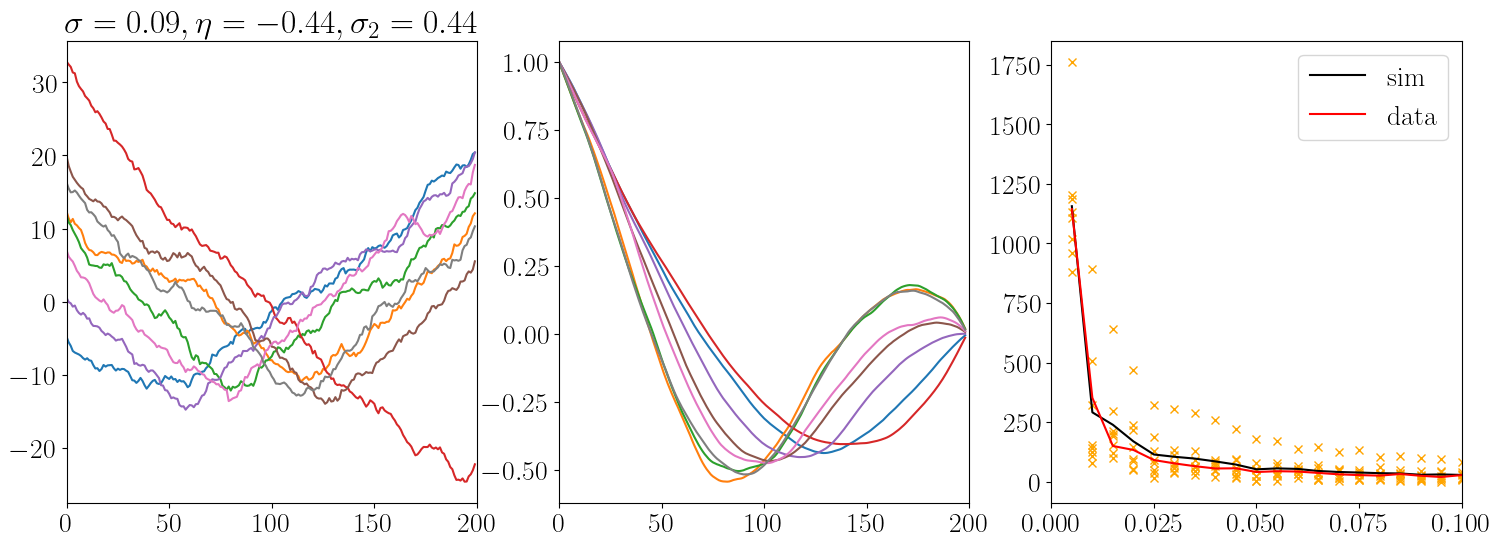

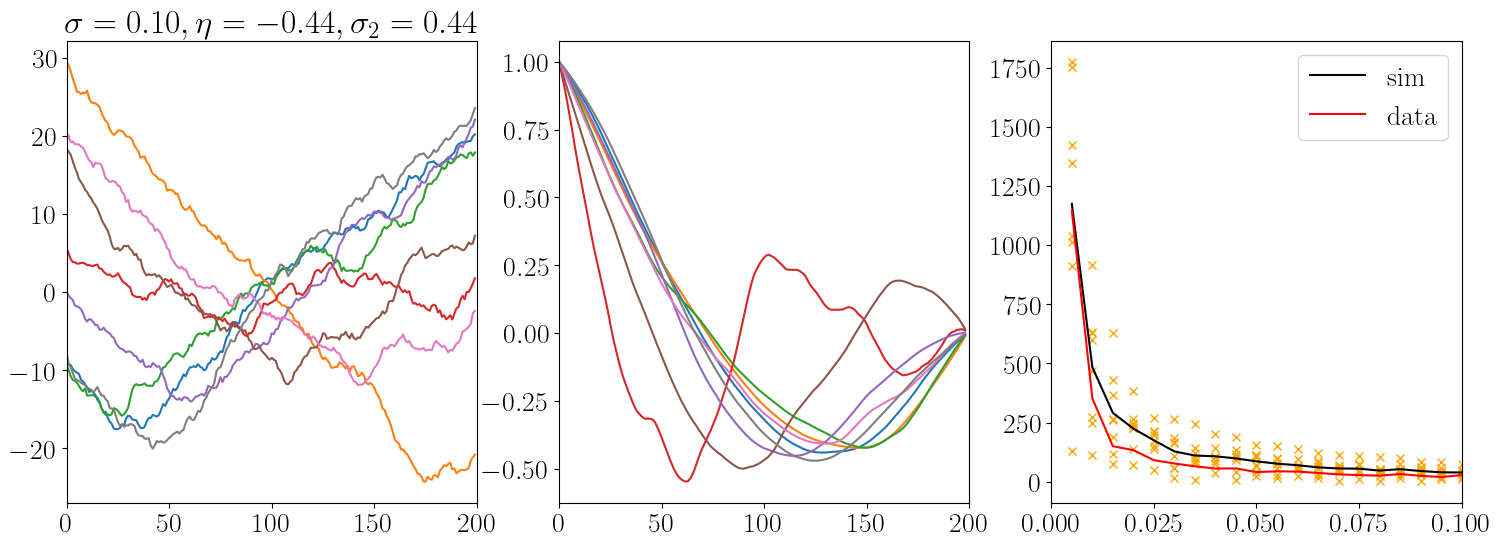

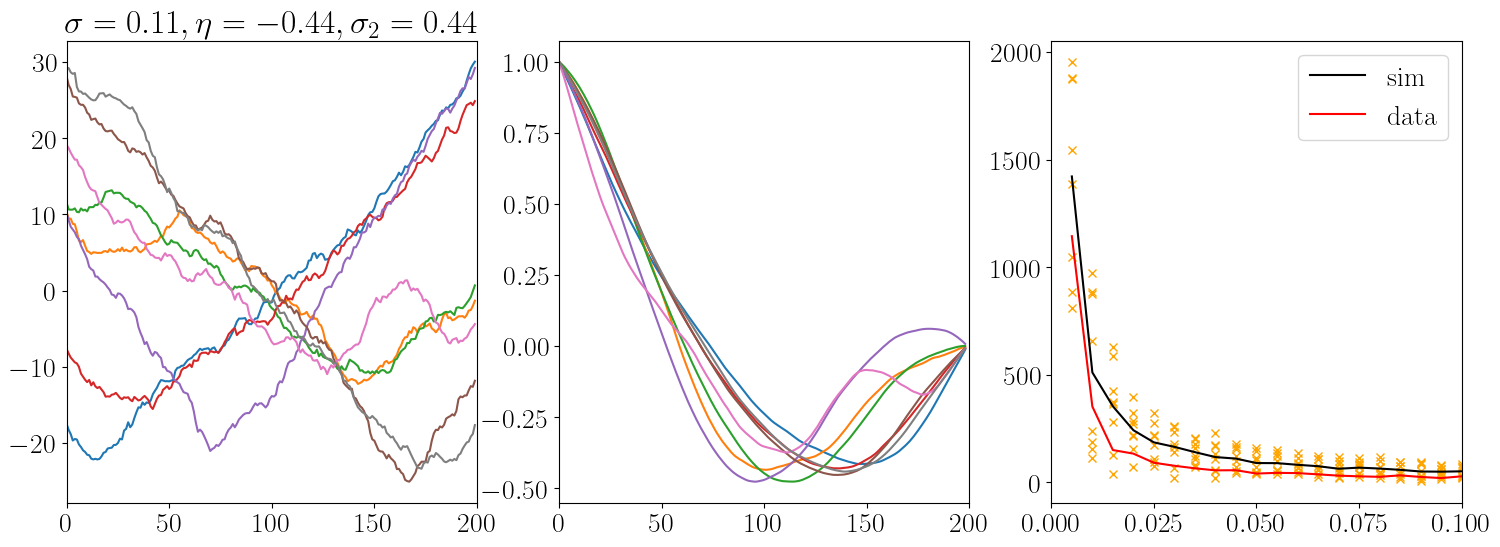

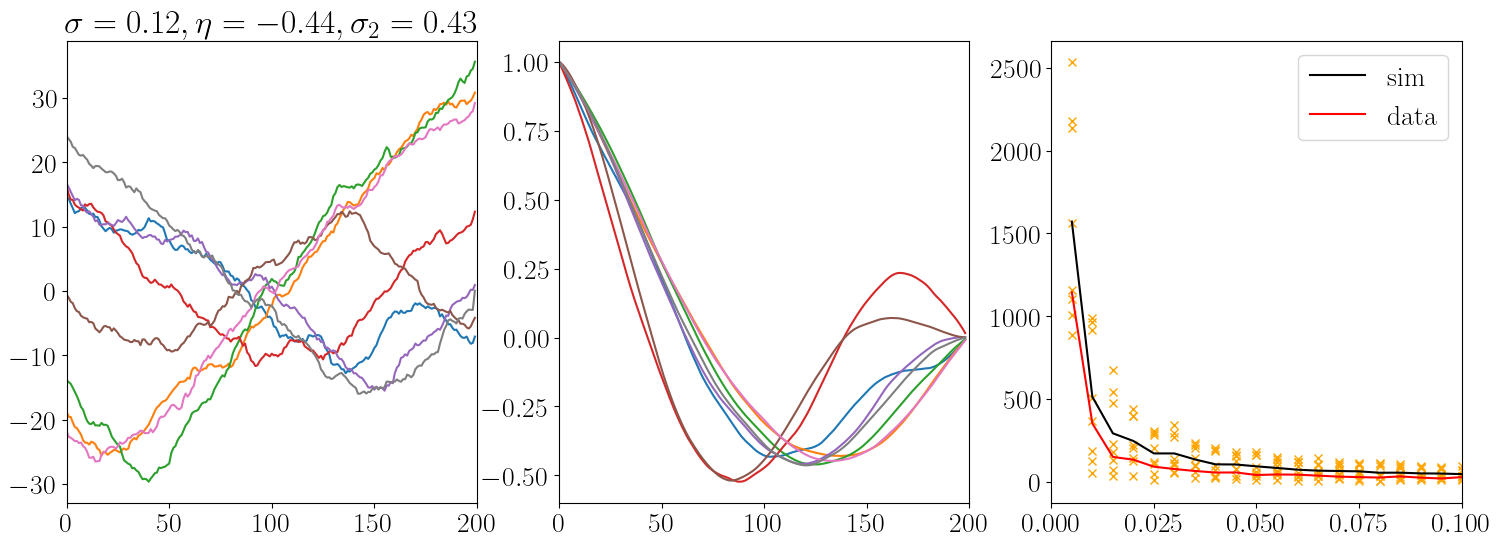

In [14]:
i = 0 
for (a, sigma) in enumerate(sigmas):
    noise = np.sqrt(0.45**2-sigma**2)
    theta_ks = [] 
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for (n, seed) in enumerate(seeds): 
        theta = data[i]
        x = theta - np.mean(theta)
        axes[0].plot(x, color=plt.cm.tab10(n))

        L = len(theta)
        corr = np.correlate(x, x, mode='full')
        axes[1].plot(corr[L:]/corr[L], color=plt.cm.tab10(n))


        freq = np.fft.rfftfreq(L)[1:]
        theta_k = np.abs(np.fft.rfft(x))[1:]
        axes[2].plot(freq, theta_k, 'x', color='orange')
        theta_ks.append(theta_k)
        i += 1
        
    
    m = np.mean(theta_ks, axis=0)
    print(np.sum(np.abs(m-mtheta_k)))
    axes[2].plot(freq, m, color='black', label='sim')
    axes[2].plot(freq, mtheta_k, color='red', label='data')
    axes[2].legend()

    axes[0].set_xlim([0, 200])
    axes[1].set_xlim([0, 200])
    axes[2].set_xlim([0, 0.1])

    axes[0].set_title(r'$\sigma={:.2f}, \eta={:.2f}, \sigma_2={:.2f}$'.format(sigma, eta, noise))

In [50]:
# Set up model parameters 
epsilon = 1
eta = -0.44
sigma = 0.09
mean_omega = 0
noise = np.sqrt(0.45**2-sigma**2)


# Set up simulation parameters 
L = 200
T = 1e4 # total time of the simulation 
n_frames = T # number of time points recorded in the end 
init = np.zeros(L)
grad = 1.3
grads = [-grad, grad]
seeds = [None]*8

data = [] 
# Initialise the model and run the simulation 

for seed in seeds: 
    model = KuramotoVF(epsilon, eta, sigma, mean_omega, noise=noise, BC='grad', grad=grads)
    model.initialise(L, T, n_frames, init=init, seed=seed)
    model.evolve(dt=1e-2) 

    phases = np.copy(model.res[-1]) % (2*np.pi)
    shift(phases)
    data.append(phases)

100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 417.99it/s]


In [51]:
np.save('Sims/SSK_data_sigma={}_eta={}_samples.npy'.format(sigma, eta), data)

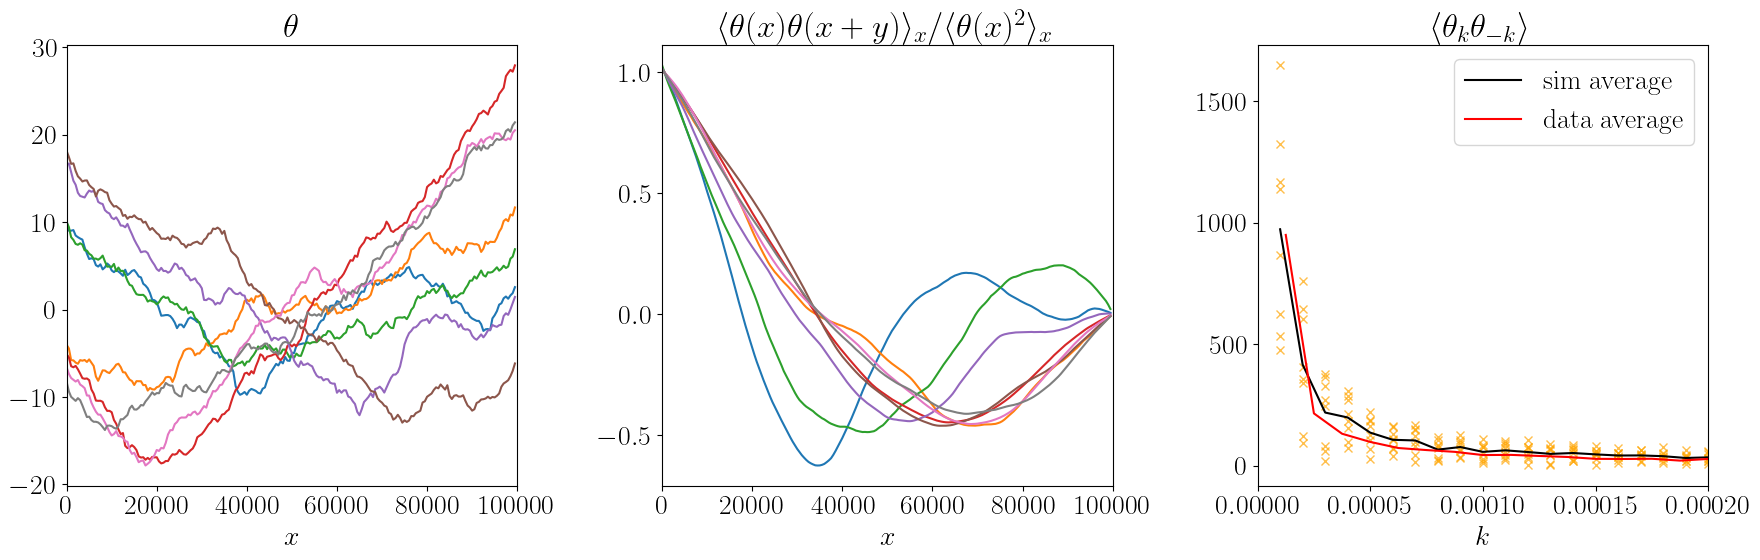

In [53]:
# replot the best fit parameters 
theta_ks = [] 

L = 200
x = np.arange(L)*500

plt.rc('text', usetex=True)
plt.rc('font', size=20, family='serif')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for (n, theta) in enumerate(data): 
    theta = theta - np.mean(theta)
    axes[0].plot(x, theta, color=plt.cm.tab10(n))

    L = len(theta)
    corr = np.correlate(theta, theta, mode='full')
    axes[1].plot(x, corr[L-1:]/corr[L], color=plt.cm.tab10(n))


    freq = np.fft.rfftfreq(L)[1:]
    theta_k = np.abs(np.fft.rfft(theta))[1:]
    axes[2].plot(freq/500, theta_k, 'x', color='orange', alpha=0.7)
    theta_ks.append(theta_k)
    i += 1
        
    
m = np.mean(theta_ks, axis=0)
axes[2].plot(freq/500, m, color='black', label='sim average')
axes[2].plot(mfreq/500, mtheta_k, color='red', label='data average')
axes[2].legend()

axes[0].set_xlim([0, L*500])
axes[1].set_xlim([0, L*500])
axes[2].set_xlim([0, 0.1/500])
axes[0].set_xlabel(r'$x$')
axes[1].set_xlabel(r'$x$')
axes[2].set_xlabel(r'$k$')

axes[0].set_title(r'$\theta$')
axes[1].set_title(r'$\langle \theta(x)\theta(x+y) \rangle_x / \langle \theta(x)^2 \rangle_x $')
axes[2].set_title(r'$\langle \theta_k \theta_{-k} \rangle $')
plt.tight_layout()
plt.savefig('Figures/SSK_sim.pdf')
plt.show() 